### Tune and test NERVE

In [1]:
import subprocess, os
import pandas as pd
from code import Protein
import numpy as np
from scipy.stats import hypergeom as hg
import matplotlib.pyplot as plt
import random

In [2]:
class RunNerve():
    """Class to store nerve parameters and run NERVE program"""
    def __init__(self):
        """Initiate arguments and program path"""
        self.args = {'annotation': True, 'e_value': 1e-10, 'gram': None, 'minlength': 9, 'mismatch': 1,
                     'mouse': True, 'mouse_peptides_sum_limit': .15, 'proteome1': None, 'proteome2': None, 
                     'p_ad_extracellular_filter': .38, 'p_ad_no_citoplasm_filter': .46, 'padlimit': .5, 
                     'razor': True, 'razlen': 50, 'select': True, 'substitution': 3, 
                     'transmemb_doms_limit': 3, 'virlimit': .5, 'virulent': True, 'working_dir': None, 
                     'NERVE_dir': '../../', 'iFeature_dir': '/iFeature', 'DeepFri_dir': '/DeepFri'
                     }
        self.program = "../../code/NERVE.py"

    def print_args(self):
        print(f'Arguments are:\n{self.args}')
        print(f'NERVE executable path is:\n{self.program}')
    
    def run(self):
        """Pass commands to line
        program: command/program to run
        args: arguments"""
        
        program = self.program
        args = self.args
        for key in args:
            args[key] = str(args[key])
        
        args_list = []
        for item in args.items():
            args_list.append(f'--{item[0]}')
            args_list.append(item[1])
        cmd = ['python3'] + [program] + args_list
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        output, error = process.communicate()
        return output, error

In [4]:
class Localization:
        """class to store and handle protein subcellular localizations"""
        def __init__(self, localization, reliability):
            self.localization = str(localization)
            self.reliability = float(reliability)

def protein_loader(proteome):
    
    if type(proteome) != pd.DataFrame:
        df = pd.read_csv(proteome)
    else:
        df = proteome
    df = df.astype(object).where(pd.notnull(df),None)
    list_of_proteins = []
    for index, row in df.iterrows():
        protein = Protein.Protein(row['id'], row['sequence'])
        protein.accession = row['uniprot_accession_code']
        protein.length = row['length']
        protein.transmembrane_doms = 0 if row['transmembrane_doms'] == None else row['transmembrane_doms']
        protein.localization = [Localization(row['localization'], row['localization score'])]
        protein.p_vir = row['virulence_probability']
        protein.p_ad = row['adhesin_probability']
        protein.conservation_score = row['conservation_score']
        protein.shared_human_peps = 0 if row['shared_human_peps'] == None else row['shared_human_peps']
        protein.shared_mouse_peps = 0 if row['shared_mouse_peps'] == None else row['shared_mouse_peps']
        protein.shared_conserv_proteome_peps = 0 if row['shared_conserv_proteome_peps'] == None else row['shared_conserv_proteome_peps']
        protein.sapiens_peptides_sum = 0 if row['human_peptides_sum'] == None else row['human_peptides_sum']
        protein.mouse_peptides_sum = 0 if row['mouse_peptides_sum'] == None else row['mouse_peptides_sum']
        protein.annotations = row['annotations']
        protein.list_of_peptides_from_comparison_with_mhcpep_sapiens = [] if \
        row['list_of_peptides_from_comparison_with_mhcpep_sapiens'] == None else \
        [peptide for peptide in range(len(row['list_of_peptides_from_comparison_with_mhcpep_sapiens']))]
        protein.list_of_peptides_from_comparison_with_mhcpep_mouse = [] if \
        row['list_of_peptides_from_comparison_with_mhcpep_mouse'] == None else \
        [peptide for peptide in range(len(row['list_of_peptides_from_comparison_with_mhcpep_mouse']))]
        protein.original_sequence_if_razor = row['original_sequence_if_razor']
        protein.tmhmm_seq = row['tmhmm_seq']
        list_of_proteins.append(protein)
    return list_of_proteins

def select(list_of_proteins, transmemb_doms_limit,
           padlimit, mouse, mouse_peptides_sum_limit, virlimit, virulent)->list:
    """Selects suitable candidate proteins for vaccine production"""
        
    final_list = []
    for protein in list_of_proteins:
        if protein.localization[0].localization == "Cytoplasmic" and protein.p_ad < padlimit: continue
        
        if virulent == "True":
            if protein.p_vir < virlimit : continue
        if mouse == "True":
            if protein.mouse_peptides_sum > mouse_peptides_sum_limit: continue 
            if len(protein.list_of_peptides_from_comparison_with_mhcpep_mouse) >= 1: continue 
        
        final_list.append(protein)
    return final_list  


### Prepare files for tuning

In [38]:
# prepare files for tuning
def to_fasta(df, outfile):
    """Converts pandas cells to fasta"""
    outfile = open(outfile, 'w')
    for index, row in df.iterrows():
        outfile.write('>' + row['protein']+ '_' + row['organism name'] + '\n'\
                      + row['sequence'].replace(" ", "") + '\n')
    outfile.close()

In [13]:
# NERVE2

df = pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx', sheet_name = 'nerve_2_tests')
df = df[df['Nerve_2_test'] != 1]
df_neg = df[df['gram'] == '-']
df_pos = df[df['gram'] == '+']
to_fasta(df_neg, './tuning/gram_neg_2/gram_neg_2.fasta')
to_fasta(df_pos, './tuning/gram_pos_2/gram_pos_2.fasta')

In [14]:
# NERVE 1

df = pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx', sheet_name = 'nerve_1_tests')
df_neg = df[df['gram'] == '-']
df_pos = df[df['gram'] == '+']
to_fasta(df_neg, './tuning/gram_neg_1/gram_neg_1.fasta')
to_fasta(df_pos, './tuning/gram_pos_1/gram_pos_1.fasta')

In [19]:
# Run nerve on gram positive and negative datasets

for test_set, gram in zip(['gram_neg_1', 'gram_pos_1', 'gram_neg_2', 'gram_pos_2'], 
                         ['n', 'p', 'n', 'p']):
    
    nerve_run = RunNerve()
    nerve_run.args['proteome1'] = f'./tuning/{test_set}/{test_set}.fasta'
    nerve_run.args['gram'] = gram
    nerve_run.args.pop('proteome2')
    nerve_run.args['select'] = False
    nerve_run.args['working_dir'] = f'./tuning/{test_set}/'
    out, err = nerve_run.run()


### Run tuning

In [5]:
len(pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx', sheet_name = 'nerve_2_tests'))

152

In [6]:
nerve_2_tuning = pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx', sheet_name = 'nerve_2_tests')
nerve_2_tuning = nerve_2_tuning[(nerve_2_tuning['Nerve_2_test'] != 1)]
tuning_proteomes  = list(nerve_2_tuning['Proteome ID'].unique())
print(f'Proteomes: {len(tuning_proteomes)}, antigens: {len(nerve_2_tuning)}')

Proteomes: 34, antigens: 108


In [7]:
# run parameter grid search and collect accuracy, coverage, p-value
CONDITIONS = [[i/100, s/100] for i in range(50, 100, 5) for s in range(50, 100, 5)]

# read in precomputaded nerve predictions on known antigens
nerve_2_tuning_results = pd.read_csv('./tuning/nerve_2_tuning/vaccine_candidates.csv')

outlist = []
for condition in CONDITIONS:
    number_of_selected_proteins = 0
    number_of_total_proteins = 0
    virlimit, padlimit = condition
    
    # evaluate for known antigens
    list_of_known_antigens = protein_loader(nerve_2_tuning_results)
    list_of_known_antigens_seqs = [protein.sequence for protein in list_of_known_antigens]
    selected_antigens = select(list_of_proteins = list_of_known_antigens,
                        transmemb_doms_limit = 3,
                        padlimit = padlimit, mouse = "True",
                        mouse_peptides_sum_limit = .15,
                        virlimit = virlimit, virulent = "True")
    # evaluate for proteomes
    for proteome in tuning_proteomes:
        path = os.path.join('./tuning/', proteome, 'vaccine_candidates.csv')
        list_of_proteins = protein_loader(path)
        for protein in list_of_proteins:
            if protein.sequence in list_of_known_antigens_seqs:
                list_of_proteins.remove(protein)
        selected_proteins = select(list_of_proteins = list_of_proteins,
                            transmemb_doms_limit = 3,
                            padlimit = padlimit, mouse = "True",
                            mouse_peptides_sum_limit = .15,
                            virlimit = virlimit, virulent = "True")
        # populate values
        number_of_selected_proteins += len(selected_proteins)
        number_of_total_proteins += len(list_of_proteins)
        
    number_of_selected_proteins = number_of_selected_proteins + len(selected_antigens)
    number_of_total_proteins = number_of_total_proteins + len(list_of_known_antigens)
    
    expected_bpas = round((len(list_of_known_antigens) * number_of_selected_proteins) / number_of_total_proteins, 2)
    values = [virlimit, padlimit, round((len(selected_antigens) / len(list_of_known_antigens))*100, 2),
                    round((number_of_selected_proteins / number_of_total_proteins)*100, 2),  
                   expected_bpas, round(len(selected_antigens)/expected_bpas, 2), 
                    hg.sf(len(selected_antigens)-1, 
                          number_of_total_proteins, len(list_of_known_antigens), number_of_selected_proteins)]
    print(values)
    outlist.append(values)
                  

[0.5, 0.5, 67.54, 28.14, 32.08, 2.4, 2.8925539243799913e-18]
[0.5, 0.55, 67.54, 27.99, 31.9, 2.41, 2.037112146828269e-18]
[0.5, 0.6, 67.54, 27.83, 31.73, 2.43, 1.4442962176291328e-18]
[0.5, 0.65, 67.54, 27.71, 31.59, 2.44, 1.0903818638359676e-18]
[0.5, 0.7, 66.67, 27.59, 31.45, 2.42, 4.4200171163299024e-18]
[0.5, 0.75, 66.67, 27.47, 31.32, 2.43, 3.432422350684591e-18]
[0.5, 0.8, 65.79, 27.38, 31.21, 2.4, 1.444009192640016e-17]
[0.5, 0.85, 65.79, 27.28, 31.1, 2.41, 1.1559716245153039e-17]
[0.5, 0.9, 64.91, 27.2, 31.01, 2.39, 4.9671621851522876e-17]
[0.5, 0.95, 64.04, 27.14, 30.94, 2.36, 2.133668605424246e-16]
[0.55, 0.5, 64.91, 26.01, 29.65, 2.5, 3.3597465622461343e-18]
[0.55, 0.55, 64.91, 25.86, 29.48, 2.51, 2.3797864864450677e-18]
[0.55, 0.6, 64.91, 25.71, 29.31, 2.52, 1.6853577404326246e-18]
[0.55, 0.65, 64.91, 25.6, 29.18, 2.54, 1.2801818723540701e-18]
[0.55, 0.7, 64.04, 25.47, 29.04, 2.51, 5.119636333950044e-18]
[0.55, 0.75, 64.04, 25.37, 28.92, 2.52, 3.974966152372418e-18]
[0.55, 

In [8]:
df = pd.DataFrame(outlist, columns = ['virlimit', 'padlimit', 'recall (%)',
                                'coverage (%)', 'expected_bpas', 'fold-enrichment', 'p-value'])
df

,virlimit,padlimit,recall (%),coverage (%),expected_bpas,fold-enrichment,p-value
0,0.50,0.50,67.54,28.14,32.08,2.40,2.892554e-18
1,0.50,0.55,67.54,27.99,31.90,2.41,2.037112e-18
2,0.50,0.60,67.54,27.83,31.73,2.43,1.444296e-18
3,0.50,0.65,67.54,27.71,31.59,2.44,1.090382e-18
4,0.50,0.70,66.67,27.59,31.45,2.42,4.420017e-18
...,...,...,...,...,...,...,...
95,0.95,0.75,18.42,2.20,2.50,8.40,8.291928e-14
96,0.95,0.80,17.54,2.18,2.48,8.06,7.251984e-13
97,0.95,0.85,17.54,2.15,2.45,8.16,5.806888e-13
98,0.95,0.90,16.67,2.13,2.43,7.82,4.911188e-12


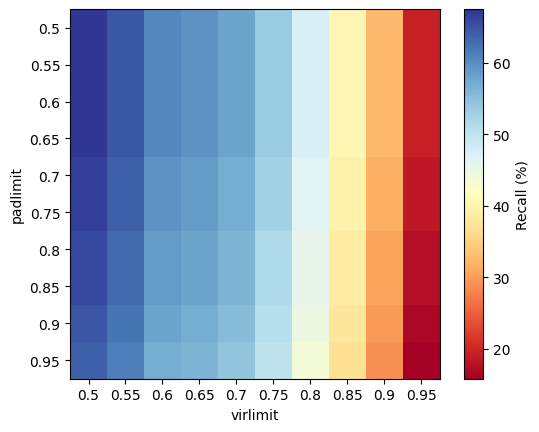

In [9]:
new_column = df.virlimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.virlimit == column)]['recall (%)'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='Recall (%)')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('virlimit')
plt.ylabel('padlimit')
plt.show()

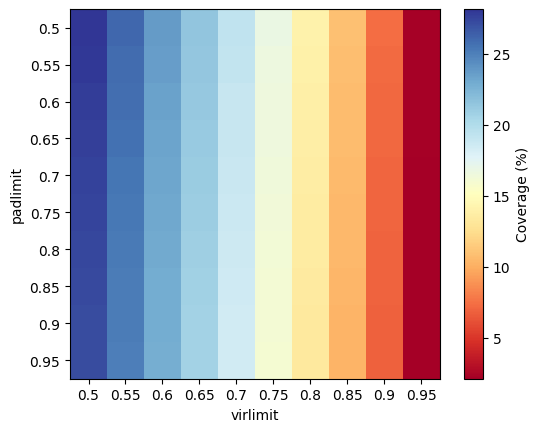

In [10]:
new_column = df.virlimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.virlimit == column)]['coverage (%)'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='Coverage (%)')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('virlimit')
plt.ylabel('padlimit')
plt.show()

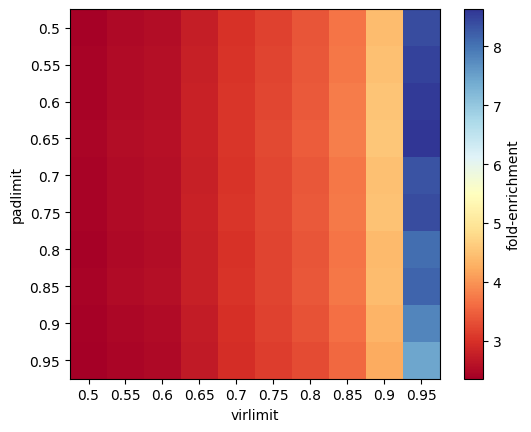

In [11]:
new_column = df.virlimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.virlimit == column)]['fold-enrichment'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='fold-enrichment')# format='%.0e')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('virlimit')
plt.ylabel('padlimit')
plt.show()

In [11]:
df.to_csv('./tuning/NERVE_2_tuning.csv', index=False)

In [12]:
# same on nerve 1 dataset

nerve_1_tuning = pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx', sheet_name = 'nerve_1_tests')
nerve_1_tuning = nerve_1_tuning[nerve_1_tuning['nerve_1_test'] != 1]
tuning_proteomes  = list(nerve_1_tuning['Proteome ID'].unique())
print(f'Proteomes: {len(tuning_proteomes)}, antigens: {len(nerve_1_tuning)}')

Proteomes: 9, antigens: 37


In [13]:
# run parameter grid search and collect accuracy, coverage, p-value
CONDITIONS = [[i/100, s/100] for i in range(50, 100, 5) for s in range(50, 100, 5)]

# read in precomputaded nerve predictions on known antigens
nerve_2_tuning_results = pd.read_csv('./tuning/nerve_2_tuning/vaccine_candidates.csv')

outlist = []
for condition in CONDITIONS:
    number_of_selected_proteins = 0
    number_of_total_proteins = 0
    virlimit, padlimit = condition
    
    # evaluate for known antigens
    list_of_known_antigens = protein_loader(nerve_2_tuning_results)
    list_of_known_antigens_seqs = [protein.sequence for protein in list_of_known_antigens]
    selected_antigens = select(list_of_proteins = list_of_known_antigens,
                        transmemb_doms_limit = 3,
                        padlimit = padlimit, mouse = "True",
                        mouse_peptides_sum_limit = .15,
                        virlimit = virlimit, virulent = "True")
    # evaluate for proteomes
    for proteome in tuning_proteomes:
        path = os.path.join('./tuning/', proteome, 'vaccine_candidates.csv')
        list_of_proteins = protein_loader(path)
        for protein in list_of_proteins:
            if protein.sequence in list_of_known_antigens_seqs:
                list_of_proteins.remove(protein)
        selected_proteins = select(list_of_proteins = list_of_proteins,
                            transmemb_doms_limit = 3,
                            padlimit = padlimit, mouse = "True",
                            mouse_peptides_sum_limit = .15,
                            virlimit = virlimit, virulent = "True")
        # populate values
        number_of_selected_proteins += len(selected_proteins)
        number_of_total_proteins += len(list_of_proteins)
        
    number_of_selected_proteins = number_of_selected_proteins + len(selected_antigens)
    number_of_total_proteins = number_of_total_proteins + len(list_of_known_antigens)
    
    expected_bpas = round((len(list_of_known_antigens) * number_of_selected_proteins) / number_of_total_proteins, 2)
    values = [virlimit, padlimit, round((len(selected_antigens) / len(list_of_known_antigens))*100, 2),
                    round((number_of_selected_proteins / number_of_total_proteins)*100, 2),  
                   expected_bpas, round(len(selected_antigens)/expected_bpas, 2), 
                    hg.sf(len(selected_antigens)-1, 
                          number_of_total_proteins, len(list_of_known_antigens), number_of_selected_proteins)]
    #print(values)
    outlist.append(values)

In [14]:
df = pd.DataFrame(outlist, columns = ['virlimit', 'padlimit', 'recall (%)',
                                'coverage (%)', 'expected_bpas', 'fold-enrichment', 'p-value'])
df

,virlimit,padlimit,recall (%),coverage (%),expected_bpas,fold-enrichment,p-value
0,0.50,0.50,90.91,31.70,20.41,2.94,9.499424e-24
1,0.50,0.55,90.91,31.67,20.41,2.94,9.030399e-24
2,0.50,0.60,90.91,31.63,20.38,2.94,8.440227e-24
3,0.50,0.65,90.91,31.61,20.35,2.95,8.022601e-24
4,0.50,0.70,90.91,31.58,20.32,2.95,7.690127e-24
...,...,...,...,...,...,...,...
95,0.95,0.75,86.36,18.27,11.91,4.79,3.748156e-33
96,0.95,0.80,86.36,18.11,11.85,4.81,2.348503e-33
97,0.95,0.85,86.36,18.01,11.76,4.85,1.740405e-33
98,0.95,0.90,83.33,17.91,11.73,4.69,7.916968e-31


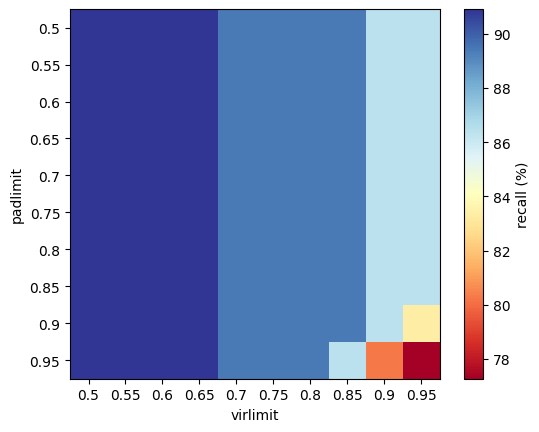

In [15]:
new_column = df.virlimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.virlimit == column)]['recall (%)'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='recall (%)')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('virlimit')
plt.ylabel('padlimit')
plt.show()

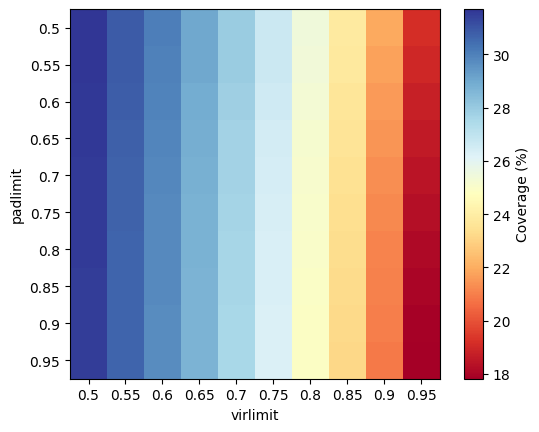

In [16]:
new_column = df.virlimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.virlimit == column)]['coverage (%)'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='Coverage (%)')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('virlimit')
plt.ylabel('padlimit')
plt.show()

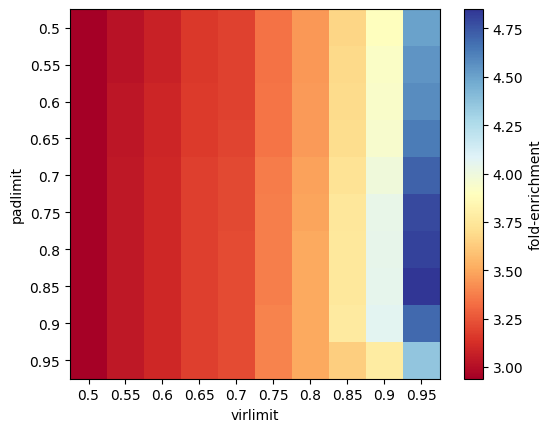

In [17]:
new_column = df.virlimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.virlimit == column)]['fold-enrichment'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='fold-enrichment')# format='%.0e')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('virlimit')
plt.ylabel('padlimit')
plt.show()

In [18]:
df.to_csv('./tuning/NERVE_1_tuning.csv', index=False)

### Run k-fold cross-validation on NERVE_2 data

In [19]:
nerve_2_tuning = pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx',
                               sheet_name = 'nerve_2_tests')
nerve_2_tuning = nerve_2_tuning[(nerve_2_tuning['Nerve_2_test'] != 1)]

In [29]:
# find split with lower difference bwtween groups
sem = 100
random_num = 0
for i in range(2000):
    proteomes = nerve_2_tuning['Proteome ID'].unique()
    random.seed(i)
    random.shuffle(proteomes)
    outlist = []
    for index, row in nerve_2_tuning.iterrows():
        proteome = row['Proteome ID']
        if proteome in proteomes[0:7]:
            outlist.append(0)     
        if proteome in proteomes[7:15]:
            outlist.append(1)
        if proteome in proteomes[15:22]:
            outlist.append(2)
        if proteome in proteomes[22:34]:
            outlist.append(3)
    nerve_2_tuning['class'] = outlist
    tmp_sem = nerve_2_tuning[['class']].value_counts().sem()
    if tmp_sem < sem:
        sem = tmp_sem
        random_num = i
print(sem, random_num)

1.8708286933869707 476


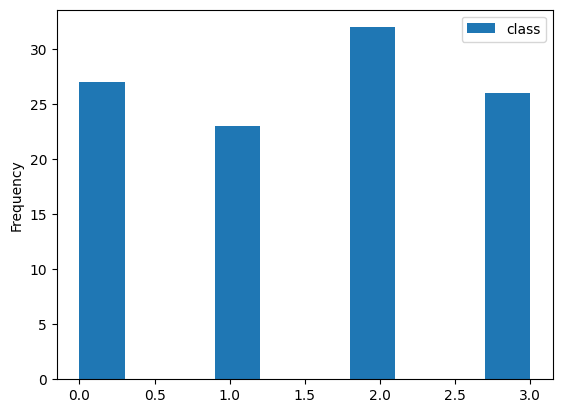

In [30]:
# split the dataset into 5

proteomes = nerve_2_tuning['Proteome ID'].unique()
random.seed(476)
random.shuffle(proteomes)
outlist = []
for index, row in nerve_2_tuning.iterrows():
    proteome = row['Proteome ID']
    if proteome in proteomes[0:7]:
        outlist.append(0)     
    if proteome in proteomes[7:15]:
        outlist.append(1)
    if proteome in proteomes[15:22]:
        outlist.append(2)
    if proteome in proteomes[22:34]:
        outlist.append(3)
nerve_2_tuning['class'] = outlist
tmp_sem = nerve_2_tuning[['class']].plot.hist()

In [31]:
# perform cross validation
outvalues = []
for split in nerve_2_tuning['class'].unique():
    test_set = nerve_2_tuning[nerve_2_tuning['class'] != split]
    val_set = nerve_2_tuning[nerve_2_tuning['class'] == split]
    test_proteomes = list(test_set['Proteome ID'].unique())
    val_proteomes = list(val_set['Proteome ID'].unique())
    test_antigens = list(test_set['protein'].unique())
    val_antigens = list(val_set['protein'].unique())
    
    # run parameter grid search and collect accuracy, coverage, p-value
    CONDITIONS = [[i/100, s/100] for i in range(50, 100, 5) for s in range(50, 100, 5)]

    # read in precomputaded nerve predictions on known antigens
    nerve_2_tuning_results = pd.read_csv('./tuning/nerve_2_tuning/vaccine_candidates.csv')
    nerve_2_tuning_results.id = [element[0] for element in nerve_2_tuning_results.id.str.split('_')]
    nerve_2_tuning_results = nerve_2_tuning_results[nerve_2_tuning_results.id.isin(test_antigens)]

    outlist = []
    for condition in CONDITIONS:
        number_of_selected_proteins = 0
        number_of_total_proteins = 0
        virlimit, padlimit = condition

        # evaluate for known antigens
        list_of_known_antigens = protein_loader(nerve_2_tuning_results)
        list_of_known_antigens_seqs = [protein.sequence for protein in list_of_known_antigens]
        selected_antigens = select(list_of_proteins = list_of_known_antigens,
                            transmemb_doms_limit = 3,
                            padlimit = padlimit, mouse = "True",
                            mouse_peptides_sum_limit = .15,
                            virlimit = virlimit, virulent = "True")
        # evaluate for proteomes
        for proteome in test_proteomes:
            path = os.path.join('./tuning/', proteome, 'vaccine_candidates.csv')
            list_of_proteins = protein_loader(path)
            for protein in list_of_proteins:
                if protein.sequence in list_of_known_antigens_seqs:
                    list_of_proteins.remove(protein)
            selected_proteins = select(list_of_proteins = list_of_proteins,
                                transmemb_doms_limit = 3,
                                padlimit = padlimit, mouse = "True",
                                mouse_peptides_sum_limit = .15,
                                virlimit = virlimit, virulent = "True")
            # populate values
            number_of_selected_proteins += len(selected_proteins)
            number_of_total_proteins += len(list_of_proteins)
        
        number_of_selected_proteins = number_of_selected_proteins + len(selected_antigens)
        number_of_total_proteins = number_of_total_proteins + len(list_of_known_antigens)
        
        expected_bpas = round((len(list_of_known_antigens) * number_of_selected_proteins /\
                               number_of_total_proteins,2)
        recall = round((len(selected_antigens) / len(list_of_known_antigens))*100, 2)
        coverage = round((number_of_selected_proteins / number_of_total_proteins)*100, 2)
        fold_enrichment = round(len(selected_antigens)/expected_bpas, 2)
        p_value = hg.sf(len(selected_antigens)-1, 
                              number_of_total_proteins, len(list_of_known_antigens), number_of_selected_proteins)
        outlist.append([virlimit, padlimit, recall, coverage, expected_bpas, fold_enrichment,p_value])
        
    # get padlimit and virlimit values with lower fold-enrichment
    df = pd.DataFrame(outlist, columns = ['virlimit', 'padlimit', 'recall (%)',
                                'coverage (%)', 'expected_bpas', 'fold-enrichment', 'p-value'])
    best_values_df = df[df['fold-enrichment'] == min(df['fold-enrichment'])]
    virlimit = best_values_df[
        best_values_df['coverage (%)'] == min(best_values_df['coverage (%)'])]['virlimit'].unique()[0]
    padlimit = best_values_df[
        best_values_df['coverage (%)'] == min(best_values_df['coverage (%)'])]['padlimit'].unique()[0]
    print(split, df[df['fold-enrichment'] == min(df['fold-enrichment'])])
    # apply lower values to validation set
    
    # read in precomputaded nerve predictions on known antigens
    nerve_2_tuning_results = pd.read_csv('./tuning/nerve_2_tuning/vaccine_candidates.csv')
    nerve_2_tuning_results.id = [element[0] for element in nerve_2_tuning_results.id.str.split('_')]
    nerve_2_tuning_results = nerve_2_tuning_results[nerve_2_tuning_results.id.isin(val_antigens)]


    # evaluate for known antigens
    list_of_known_antigens = protein_loader(nerve_2_tuning_results)
    list_of_known_antigens_seqs = [protein.sequence for protein in list_of_known_antigens]
    selected_antigens = select(list_of_proteins = list_of_known_antigens,
                        transmemb_doms_limit = 3,
                        padlimit = padlimit, mouse = "True",
                        mouse_peptides_sum_limit = .15,
                        virlimit = virlimit, virulent = "True")
    # evaluate for proteomes
    for proteome in val_proteomes:
        path = os.path.join('./tuning/', proteome, 'vaccine_candidates.csv')
        list_of_proteins = protein_loader(path)
        for protein in list_of_proteins:
                if protein.sequence in list_of_known_antigens_seqs:
                    list_of_proteins.remove(protein)
        selected_proteins = select(list_of_proteins = list_of_proteins,
                            transmemb_doms_limit = 3,
                            padlimit = padlimit, mouse = "True",
                            mouse_peptides_sum_limit = .15,
                            virlimit = virlimit, virulent = "True")
        # populate values
        number_of_selected_proteins += len(selected_proteins)
        number_of_total_proteins += len(list_of_proteins)
    
    number_of_selected_proteins = number_of_selected_proteins + len(selected_antigens)
    number_of_total_proteins = number_of_total_proteins + len(list_of_known_antigens)
                              
    expected_bpas = round((len(list_of_known_antigens) * number_of_selected_proteins /\
                               number_of_total_proteins,2)
    recall = round((len(selected_antigens) / len(list_of_known_antigens))*100, 2)
    coverage = round((number_of_selected_proteins / number_of_total_proteins)*100, 2)
    fold_enrichment = round(len(selected_antigens)/expected_bpas, 2)
    p_value = hg.sf(len(selected_antigens)-1, 
                          number_of_total_proteins, len(list_of_known_antigens), number_of_selected_proteins)
    outvalues.append([split, virlimit, padlimit, recall, coverage, expected_bpas, fold_enrichment,p_value])
    print([split, virlimit, padlimit, recall, coverage, expected_bpas, fold_enrichment,p_value])

2     virlimit  padlimit  recall (%)  coverage (%)  expected_bpas  \
26       0.6      0.80       65.79         28.66          12.54   
27       0.6      0.85       65.79         28.61          12.54   
28       0.6      0.90       65.79         28.57          12.54   
29       0.6      0.95       65.79         28.54          12.54   

    fold-enrichment       p-value  
26             3.99  2.099680e-11  
27             3.99  1.958435e-11  
28             3.99  1.856866e-11  
29             3.99  1.783228e-11  
[2, 0.6, 0.95, 78.12, 19.86, 9.35, 2.67, 2.135460200177704e-12]
0     virlimit  padlimit  recall (%)  coverage (%)  expected_bpas  \
16      0.55      0.80       76.54         29.64          13.86   
17      0.55      0.85       76.54         29.60          13.86   
18      0.55      0.90       76.54         29.56          13.86   
19      0.55      0.95       76.54         29.54          13.86   

    fold-enrichment       p-value  
16             4.47  3.786220e-18  
17      

In [33]:
cv_results = pd.DataFrame(outvalues, columns = ['split', 'virlimit', 'padlimit', 'recall',
                                                'coverage', 'expected_bpas', 'fold_enrichment', 'p_value']) 
cv_results

,split,virlimit,padlimit,recall,coverage,expected_bpas,fold_enrichment,p_value
0,2,0.60,0.95,78.12,19.86,9.35,2.67,2.135460e-12
1,0,0.55,0.95,55.56,19.99,7.19,2.09,4.742265e-05
2,1,0.55,0.95,78.26,20.77,6.08,2.96,5.823336e-09
3,3,0.50,0.90,80.77,21.87,4.50,4.67,2.775943e-10


### Run NERVE with the optimal parameters on the test set

In [42]:
# NERVE2

df = pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx', sheet_name = 'nerve_2_tests')
df = df[df['Nerve_2_test'] == 1]
df_neg = df[df['gram'] == '-']
df_pos = df[df['gram'] == '+']
to_fasta(df_neg, './test/gram_neg_2/gram_neg_2.fasta')
to_fasta(df_pos, './test/gram_pos_2/gram_pos_2.fasta')

In [43]:
# Run nerve on gram positive and negative datasets

for test_set, gram in zip(['gram_neg_2', 'gram_pos_2'], 
                         ['n', 'p']):
    
    nerve_run = RunNerve()
    nerve_run.args['proteome1'] = f'./test/{test_set}/{test_set}.fasta'
    nerve_run.args['gram'] = gram
    nerve_run.args.pop('proteome2')
    nerve_run.args['select'] = False
    nerve_run.args['working_dir'] = f'./test/{test_set}/'
    out, err = nerve_run.run()

Traceback (most recent call last):
  File "../../code/NERVE.py", line 426, in <module>
    main()
  File "../../code/NERVE.py", line 294, in main
    list_of_fasta_proteins, proteome1_new_path = quality_control(args.proteome1, args.working_dir, upload=True)
  File "/NERVE/code/Quality_control.py", line 127, in quality_control
    fasta_list = is_fasta(path_to_fasta)    
  File "/NERVE/code/Quality_control.py", line 103, in is_fasta
    raise ValueError(f'{filename} is not in fasta format')
ValueError: ./test/gram_neg_1/proteome1.fasta is not in fasta format
Traceback (most recent call last):
  File "../../code/NERVE.py", line 426, in <module>
    main()
  File "../../code/NERVE.py", line 294, in main
    list_of_fasta_proteins, proteome1_new_path = quality_control(args.proteome1, args.working_dir, upload=True)
  File "/NERVE/code/Quality_control.py", line 127, in quality_control
    fasta_list = is_fasta(path_to_fasta)    
  File "/NERVE/code/Quality_control.py", line 103, in is_fasta


In [46]:

# read in precomputaded nerve predictions on known antigens
nerve_2_test_results = pd.read_csv('./test/nerve_2_test/vaccine_candidates.csv')

nerve_2_test = pd.read_excel('../../database/antigens/test_antigens_summary_v2.xlsx',
                               sheet_name = 'nerve_2_tests')
nerve_2_test = nerve_2_test[nerve_2_test['Nerve_2_test'] == 1]
test_proteomes  = list(nerve_2_test['Proteome ID'].unique())

outlist = []
number_of_selected_proteins = 0
number_of_total_proteins = 0
virlimit = .5
padlimit = .9

# evaluate for known antigens
list_of_known_antigens = protein_loader(nerve_2_test_results)
selected_antigens = select(list_of_proteins = list_of_known_antigens,
                    transmemb_doms_limit = 3,
                    padlimit = padlimit, mouse = "True",
                    mouse_peptides_sum_limit = .15,
                    virlimit = virlimit, virulent = "True")
# evaluate for proteomes
for proteome in test_proteomes:
    path = os.path.join('./tuning/', proteome, 'vaccine_candidates.csv')
    list_of_proteins = protein_loader(path)
    selected_proteins = select(list_of_proteins = list_of_proteins,
                        transmemb_doms_limit = 3,
                        padlimit = padlimit, mouse = "True",
                        mouse_peptides_sum_limit = .15,
                        virlimit = virlimit, virulent = "True")
    # populate values
    number_of_selected_proteins += len(selected_proteins)
    number_of_total_proteins += len(list_of_proteins)
expected_bpas = round((len(list_of_known_antigens) * len(selected_proteins)) / len(list_of_proteins),2)
outlist.append([virlimit, padlimit, round((len(selected_antigens) / len(list_of_known_antigens))*100, 2),
                round((number_of_selected_proteins / number_of_total_proteins)*100, 2),  
               expected_bpas, round(len(selected_antigens)/expected_bpas, 2), 
                hg.sf(len(selected_antigens)-1, 
                      number_of_total_proteins, len(list_of_known_antigens), number_of_selected_proteins)])


In [49]:
df = pd.DataFrame(outlist, columns = ['virlimit', 'padlimit', 'recall',
                                        'coverage', 'expected_bpas', 'fold_enrichment', 'p_value']) 
df

,virlimit,padlimit,recall,coverage,expected_bpas,fold_enrichment,p_value
0,0.5,0.9,75.0,32.06,15.06,2.19,6.264881e-09


### Run statistics

In [2]:
proteomes = os.path.join('./tuning/')
df = pd.DataFrame()
for proteome in os.listdir(proteomes):
    tmp_df = pd.read_csv(os.path.join(proteomes, proteome, 'vaccine_candidates.csv'))
    df = df.append(tmp_df)
df['index'] = range(0, len(df))
df = df.set_index('index')
df

/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: Future

/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df)
/tmp/ipykernel_96/929528065.py:5: Future

,id,uniprot_accession_code,score,length,transmembrane_doms,localization,localization score,virulence_probability,adhesin_probability,conservation_score,...,shared_mouse_peps,shared_conserv_proteome_peps,human_peptides_sum,mouse_peptides_sum,annotations,list_of_peptides_from_comparison_with_mhcpep_sapiens,list_of_peptides_from_comparison_with_mhcpep_mouse,sequence,original_sequence_if_razor,tmhmm_seq
index,,,,,,,,,,,,,,,,,,,,,
0,sp|P9WG31|RPFA_MYCTU Resuscitation-promoting f...,P9WG31,0.9776,407,1,Extracellular,9.73,0.9074,0.9627,NaN,...,0,0,0.0000,0.0000,NaN,NaN,NaN,MSGRHRKPTTSNVSVAKIAFTGAVLGGGGIAMAAQATAATDGEWDQ...,NaN,iiiiiiiiiiiiMMMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOO...
1,sp|P9WIR7|APA_MYCTU Alanine and proline-rich s...,P9WIR7,0.9765,325,1,Extracellular,10.00,0.8753,0.9598,NaN,...,0,0,0.0000,0.0000,NaN,NaN,NaN,MHQVDPNLTRRKGRLAALAIAAMASASLVTVAVPATANADPEPAPP...,NaN,iiiiiiiiiiiiMMMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOO...
2,tr|O05857|O05857_MYCTU Conserved hypothetical ...,O05857,0.9739,186,0,CytoplasmicMembrane,9.55,0.8930,0.9692,NaN,...,0,0,0.0000,0.0000,NaN,NaN,NaN,MALGAVATAVIINSGDSTSTKAIVGAPAPRTVISTSPRPTAPTSTS...,NaN,NaN
3,"tr|O06555|O06555_MYCTU Conserved ala-, pro-ric...",O06555,0.9696,371,0,CytoplasmicMembrane,9.55,0.9110,0.9210,NaN,...,0,0,0.0000,0.0000,NaN,NaN,NaN,MRRLTNTEHRENTTVASTWSVCKGLAAVVITSAAAFALCPNAAADP...,NaN,NaN
4,tr|Q6MX49|Q6MX49_MYCTU PPE family protein PPE5...,Q6MX49,0.9663,2204,0,CytoplasmicMembrane,9.87,0.7924,0.9849,NaN,...,0,0,0.0000,0.0000,carbohydrate derivative binding,NaN,NaN,MNLVSTTSGMSGFLNVGALGSGVANVGNTISGIYNVGTSDLSTPAV...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164009,tr|A0A069PZN3|A0A069PZN3_PSEAI non-specific se...,A0A069PZN3,-15.0398,329,0,Cytoplasmic,5.41,0.7123,0.4648,NaN,...,525,0,7.6535,8.9149,"phosphotransferase activity, alcohol group as ...",NaN,NaN,MNEPLSSLELLPEEEGGANLTYFAFAAPTASAPDLPAVLPGPLPDV...,NaN,NaN
164010,tr|A0A069Q4H4|A0A069Q4H4_PSEAI Heme ABC transp...,A0A069Q4H4,-15.2197,255,0,CytoplasmicMembrane,7.88,0.1909,0.0192,NaN,...,493,0,5.7686,6.0118,purine ribonucleotide binding | purine ribonuc...,LLDEPTSAL,NaN,MLRVENLSIRRGGKTVLEGLELELRPGEMLGVLGPNGAGKSTLLGA...,NaN,NaN
164011,tr|A0A072ZED9|A0A072ZED9_PSEAI Chaperonin GroE...,A0A072ZED9,-15.3356,547,0,Cytoplasmic,9.97,0.0667,0.0085,NaN,...,152,0,0.6344,0.6289,adenyl nucleotide binding | purine nucleotide ...,"KLQERLAKL, AGDGTTTATVLAQA, GPKGRNVVL, AVKAPGFG...","TSDYDREKLQER, LGPKGRNVVL, ERLAKLAGGVAVIKV, KLA...",MAAKEVKFGDSARKKMLVGVNVLADAVKATLGPKGRNVVLDKSFGA...,NaN,NaN


array([[<Axes: title={'center': 'adhesin_probability'}>]], dtype=object)

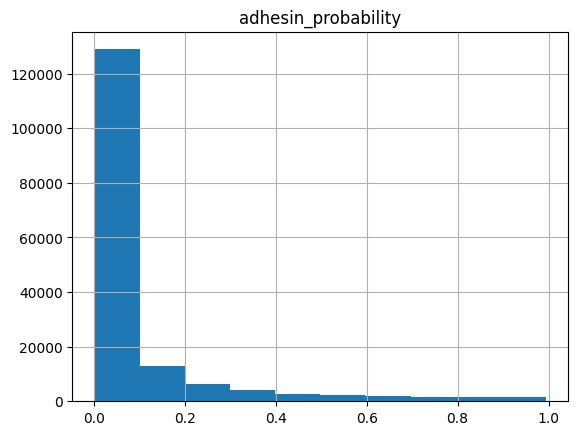

In [8]:
df.hist('adhesin_probability')

array([[<Axes: title={'center': 'virulence_probability'}>]], dtype=object)

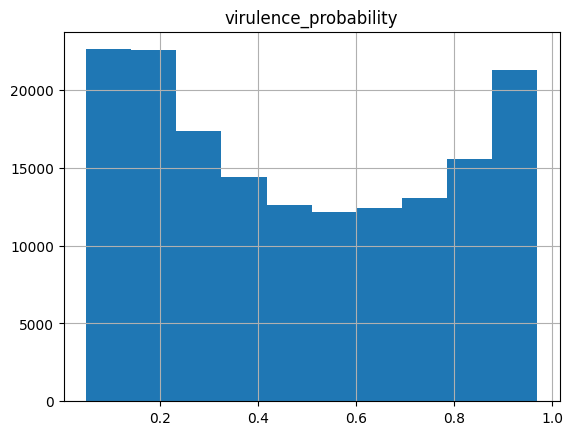

In [9]:
df.hist('virulence_probability')

In [96]:
# run k-fold cross validation to find best parameters

# read in precomputaded nerve predictions on known antigens
nerve_2_tuning_results = pd.read_csv('./tuning/nerve_2_tuning/vaccine_candidates.csv')
conditions = [[.9, .9]]
result_dic = {}
# iterate over every validation proteome
for val_proteome in tuning_proteomes:
    
    val_set_df = nerve_2_tuning[nerve_2_tuning['Proteome ID'] == val_proteome]
    tuning_set_df = nerve_2_tuning[nerve_2_tuning['Proteome ID'] != val_proteome]
    
    # iterate over conditions
    for condition in conditions:
        for tuning_proteome in list(tuning_set_df['Proteome ID'].unique()):
            path = os.path.join('./tuning/', tuning_proteome)
            if os.path.isdir(path) == True:
                
                padlimit, virlimit = condition
                # run select on known antigens
                known_antigens = val_set_df['protein'].to_list()
                list_of_known_antigens = protein_loader(
                    nerve_2_tuning_results[nerve_2_tuning_results.id.str.contains('|'.join(known_antigens))])
                selected_antigens = select(list_of_proteins = list_of_known_antigens,
                                           transmemb_doms_limit = 3,
                                           padlimit = padlimit, mouse = True,
                                           mouse_peptides_sum_limit = .15,
                                           virlimit = virlimit, virulent = True, annotation = True)
                # run select on the full proteome
                list_of_proteins = protein_loader(os.path.join(path, 'vaccine_candidates.csv'))
                selected_proteins = select(list_of_proteins = list_of_proteins,
                                           transmemb_doms_limit = 3,
                                           padlimit = padlimit, mouse = True,
                                           mouse_peptides_sum_limit = .15,
                                           virlimit = virlimit, virulent = True, annotation = True)
                # collect data:
                sum_of_antigens
                sum_of_selected_antigens
                sum_of_proteins
                sum_of_selected_proteins
                
                #print(len(selected_antigens)/len(list_of_known_antigens),
                 #     len(list_of_proteins)/len(selected_proteins))
        # evaluate condition stats  
        stat_value
        condition = stat_value  
   
    # evaluate best condition
    # use best condition to evaluate val set

1.0 9.571428571428571
1.0 7.910025706940874
1.0 7.106122448979592
1.0 6.706611570247934
1.0 7.179389312977099
1.0 6.919770773638969
1.0 5.793388429752066
1.0 5.805589307411908
1.0 5.7005405405405405
1.0 7.226053639846743
1.0 6.9004149377593365
1.0 7.110599078341014
1.0 6.953271028037383
1.0 4.832151300236407
1.0 4.320564516129032
1.0 4.8016826923076925
1.0 4.829663962920046
1.0 5.6586483390607105
1.0 6.116071428571429
1.0 8.291338582677165
1.0 8.094202898550725
1.0 7.984
1.0 9.984555984555984
1.0 5.759568204121688
1.0 5.87546699875467
1.0 5.402860548271752
1.0 6.6098901098901095
1.0 5.868383404864091
1.0 6.783042394014963
1.0 6.090909090909091
1.0 6.10091743119266
1.0 6.69205298013245
1.0 6.424050632911392
1.0 6.18475073313783
1.0 6.475095785440613
1.0 8.183333333333334
0.038461538461538464 5.633846153846154
0.038461538461538464 7.910025706940874
0.038461538461538464 7.106122448979592
0.038461538461538464 6.706611570247934
0.038461538461538464 7.179389312977099
0.038461538461538464 6.9

0.5 5.402860548271752
0.5 6.6098901098901095
0.5 5.868383404864091
0.5 6.783042394014963
0.5 6.090909090909091
0.5 6.10091743119266
0.5 6.69205298013245
0.5 6.424050632911392
0.5 6.18475073313783
0.5 6.475095785440613
0.5 8.183333333333334
0.8333333333333334 5.633846153846154
0.8333333333333334 9.571428571428571
0.8333333333333334 7.910025706940874
0.8333333333333334 7.106122448979592
0.8333333333333334 6.706611570247934
0.8333333333333334 7.179389312977099
0.8333333333333334 6.919770773638969
0.8333333333333334 5.793388429752066
0.8333333333333334 5.805589307411908
0.8333333333333334 7.226053639846743
0.8333333333333334 6.9004149377593365
0.8333333333333334 7.110599078341014
0.8333333333333334 6.953271028037383
0.8333333333333334 4.832151300236407
0.8333333333333334 4.320564516129032
0.8333333333333334 4.8016826923076925
0.8333333333333334 4.829663962920046
0.8333333333333334 5.6586483390607105
0.8333333333333334 6.116071428571429
0.8333333333333334 8.291338582677165
0.833333333333333

KeyboardInterrupt: 